In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = '/content/drive/My Drive/collab/Extended_Employee_Performance_and_Productivity_Data.csv'


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, count,min, max
from pyspark.ml import Pipeline


#Creating a Spark Session
spark = SparkSession.builder.appName("Pred&AnalysEmployeeAttrition").getOrCreate()

#Loading the data
data = spark.read.csv(path, header=True, inferSchema=True)

data = data.na.drop()

data.printSchema()
data.show(25)



root
 |-- Employee_ID: integer (nullable = true)
 |-- Department: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Job_Title: string (nullable = true)
 |-- Hire_Date: timestamp (nullable = true)
 |-- Years_At_Company: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Performance_Score: integer (nullable = true)
 |-- Monthly_Salary: double (nullable = true)
 |-- Work_Hours_Per_Week: integer (nullable = true)
 |-- Projects_Handled: integer (nullable = true)
 |-- Overtime_Hours: integer (nullable = true)
 |-- Sick_Days: integer (nullable = true)
 |-- Remote_Work_Frequency: integer (nullable = true)
 |-- Team_Size: integer (nullable = true)
 |-- Training_Hours: integer (nullable = true)
 |-- Promotions: integer (nullable = true)
 |-- Employee_Satisfaction_Score: double (nullable = true)
 |-- Resigned: boolean (nullable = true)

+-----------+----------------+------+---+----------+--------------------+--------

In [3]:
#Calculating and Displaying Unique Value Counts per Column
for column in data.columns:
    unique_count = data.select(column).distinct().count()
    print(f"{column}: Number of unique values {unique_count}")
    print("==========================================================")

Employee_ID: Number of unique values 100000
Department: Number of unique values 9
Gender: Number of unique values 3
Age: Number of unique values 39
Job_Title: Number of unique values 7
Hire_Date: Number of unique values 3650
Years_At_Company: Number of unique values 11
Education_Level: Number of unique values 4
Performance_Score: Number of unique values 5
Monthly_Salary: Number of unique values 28
Work_Hours_Per_Week: Number of unique values 31
Projects_Handled: Number of unique values 50
Overtime_Hours: Number of unique values 30
Sick_Days: Number of unique values 15
Remote_Work_Frequency: Number of unique values 5
Team_Size: Number of unique values 19
Training_Hours: Number of unique values 100
Promotions: Number of unique values 3
Employee_Satisfaction_Score: Number of unique values 401
Resigned: Number of unique values 2


In [4]:

for column in data.columns:
  unique_count = data.select(column).distinct().count()
  if unique_count <= 50:

        # Use the imported count function here
        value_counts = data.groupBy(column).agg(count("*").alias("count")).orderBy(col("count").desc())
        value_counts.show(truncate=False)

        print("====================================")
        if dict(data.dtypes)[column] !='string' :
          stats = data.agg(
              min(col(column)).alias("min_value"),
              max(col(column)).alias("max_value")
          ).collect()[0]

          min_val = stats["min_value"]
          max_val = stats["max_value"]

          # Print the results
          print(f"{column} : Minimum: {min_val}, Maximum: {max_val}")
          print("====================================")


+----------------+-----+
|Department      |count|
+----------------+-----+
|Marketing       |11216|
|Finance         |11200|
|Operations      |11181|
|IT              |11131|
|Sales           |11122|
|Legal           |11118|
|Customer Support|11116|
|HR              |10960|
|Engineering     |10956|
+----------------+-----+

+------+-----+
|Gender|count|
+------+-----+
|Male  |48031|
|Female|48001|
|Other |3968 |
+------+-----+

+---+-----+
|Age|count|
+---+-----+
|53 |2657 |
|27 |2628 |
|50 |2620 |
|28 |2617 |
|40 |2609 |
|46 |2604 |
|57 |2601 |
|24 |2598 |
|56 |2598 |
|39 |2596 |
|47 |2594 |
|43 |2594 |
|48 |2590 |
|52 |2586 |
|41 |2585 |
|26 |2584 |
|58 |2577 |
|51 |2576 |
|25 |2570 |
|31 |2566 |
+---+-----+
only showing top 20 rows

Age : Minimum: 22, Maximum: 60
+----------+-----+
|Job_Title |count|
+----------+-----+
|Specialist|14507|
|Manager   |14325|
|Technician|14285|
|Analyst   |14261|
|Engineer  |14217|
|Consultant|14210|
|Developer |14195|
+----------+-----+

+------------

In [5]:
from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder

In [6]:
from pyspark.sql.functions import  when
from pyspark.sql.types import IntegerType

In [7]:
data = data.withColumn("Resigned", when(col("Resigned"), 1).otherwise(0).cast(IntegerType())) # resigned col was a bool so i have to change it to numeric
indexer = StringIndexer(inputCol="Resigned", outputCol="attiration")
data = indexer.fit(data).transform(data)

# Assuming 'data' is your DataFrame

string_columns = ["Department", "Gender", "Job_Title", "Education_Level"]  # Identify string columns
indexers = [StringIndexer(inputCol=col, outputCol=col + "_index") for col in string_columns]

# Create a pipeline to chain the indexers
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=indexers)

# Fit and transform the data
data = pipeline.fit(data).transform(data)


# Now create the VectorAssembler using the indexed columns
assembler = VectorAssembler(
    inputCols=[col + "_index" for col in string_columns] + ["Age", "Years_At_Company", "Work_Hours_Per_Week", "Overtime_Hours", "Remote_Work_Frequency", "Training_Hours", "Promotions"],
    outputCol="features"
)

# Transform the data
data = assembler.transform(data)

In [8]:
data.select("features", "attiration").show(1000000, truncate=False)

Output hidden; open in https://colab.research.google.com to view.

In [9]:
from pyspark.sql.functions import when, lit

class_counts = data.groupBy("attiration").count().collect()

total_count = sum(row['count'] for row in class_counts)
class_weights = {
    row['attiration']: total_count / row['count']
    for row in class_counts
}

data = data.withColumn(
    "class_weights",
    when(data["attiration"] == 0.0, lit(class_weights[0.0]))
    .otherwise(lit(class_weights[1.0]))
)

data.select("attiration", "class_weights").show()

+----------+----------------+
|attiration|   class_weights|
+----------+----------------+
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
|       0.0|1.11123458162018|
+----------+----------------+
only showing top 20 rows



In [10]:
train_data, test_data = data.randomSplit([0.75, 0.25], seed=42)

In [11]:
train_data.groupBy("attiration").count().show()

+----------+-----+
|attiration|count|
+----------+-----+
|       0.0|67491|
|       1.0| 7538|
+----------+-----+



In [12]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(
    featuresCol="features",
    labelCol="attiration",
      weightCol="class_weights"
)

lr_model = lr.fit(train_data)

In [13]:
predictions = lr_model.transform(test_data)

predictions.select("features", "attiration", "prediction").show(20)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

+--------------------+----------+----------+
|            features|attiration|prediction|
+--------------------+----------+----------+
|[1.0,0.0,0.0,1.0,...|       0.0|       1.0|
|[3.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,2.0,1.0,...|       0.0|       0.0|
|[8.0,1.0,5.0,0.0,...|       0.0|       0.0|
|[8.0,0.0,3.0,0.0,...|       0.0|       0.0|
|[1.0,0.0,2.0,1.0,...|       0.0|       0.0|
|[4.0,0.0,5.0,2.0,...|       0.0|       1.0|
|[1.0,0.0,3.0,1.0,...|       0.0|       0.0|
|[6.0,0.0,5.0,0.0,...|       0.0|       0.0|
|[6.0,0.0,3.0,1.0,...|       0.0|       0.0|
|[0.0,0.0,3.0,2.0,...|       0.0|       1.0|
|[7.0,1.0,4.0,2.0,...|       0.0|       1.0|
|[6.0,0.0,4.0,0.0,...|       0.0|       1.0|
|[7.0,1.0,0.0,1.0,...|       0.0|       1.0|
|[7.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[2.0,0.0,0.0,0.0,...|       0.0|       1.0|
|[2.0,2.0,6.0,1.0,...|       0.0|       1.0|
|[7.0,0.0,6.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,6.0,0.0,...|       0.0|       1.0|
|[4.0,0.0,

In [14]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(labelCol="attiration", featuresCol="features", numTrees=50,weightCol="class_weights")
rf_model = rf.fit(train_data)
predictions = rf_model.transform(test_data)

In [15]:
predictions = rf_model.transform(test_data)

predictions.select("features", "attiration", "prediction").show(20)

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration", predictionCol="prediction", metricName="accuracy"
)
accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy}")

+--------------------+----------+----------+
|            features|attiration|prediction|
+--------------------+----------+----------+
|[1.0,0.0,0.0,1.0,...|       0.0|       1.0|
|[3.0,0.0,2.0,0.0,...|       0.0|       0.0|
|[0.0,1.0,2.0,1.0,...|       0.0|       0.0|
|[8.0,1.0,5.0,0.0,...|       0.0|       0.0|
|[8.0,0.0,3.0,0.0,...|       0.0|       0.0|
|[1.0,0.0,2.0,1.0,...|       0.0|       0.0|
|[4.0,0.0,5.0,2.0,...|       0.0|       1.0|
|[1.0,0.0,3.0,1.0,...|       0.0|       1.0|
|[6.0,0.0,5.0,0.0,...|       0.0|       0.0|
|[6.0,0.0,3.0,1.0,...|       0.0|       1.0|
|[0.0,0.0,3.0,2.0,...|       0.0|       1.0|
|[7.0,1.0,4.0,2.0,...|       0.0|       1.0|
|[6.0,0.0,4.0,0.0,...|       0.0|       0.0|
|[7.0,1.0,0.0,1.0,...|       0.0|       1.0|
|[7.0,0.0,2.0,0.0,...|       0.0|       1.0|
|[2.0,0.0,0.0,0.0,...|       0.0|       1.0|
|[2.0,2.0,6.0,1.0,...|       0.0|       0.0|
|[7.0,0.0,6.0,0.0,...|       0.0|       1.0|
|[0.0,1.0,6.0,0.0,...|       0.0|       0.0|
|[4.0,0.0,

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="attiration", predictionCol="prediction")

accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.5358615994553683
Precision: 0.8227266495742798
Recall: 0.5358615994553683
F1 Score: 0.6277671381390202


In [17]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

train_predictions = rf_model.transform(train_data)

test_predictions = rf_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration",
    predictionCol="prediction",
    metricName="accuracy"
)

train_accuracy = evaluator.evaluate(train_predictions)
test_accuracy = evaluator.evaluate(test_predictions)

print(f"Training Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

if train_accuracy > test_accuracy:
    print("The model might be overfitting. Consider regularization or simpler models.")
elif train_accuracy < test_accuracy:
    print("The model might be underfitting. Consider adding features or using a more complex model.")
else:
    print("The model generalizes well between training and test data.")

Training Accuracy: 0.5615561982700022
Test Accuracy: 0.5358615994553683
The model might be overfitting. Consider regularization or simpler models.


In [19]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration",
    predictionCol="prediction",
    metricName="accuracy"
)

cross_validator = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    seed=42
)

In [20]:
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(
    labelCol="attiration",
    predictionCol="prediction",
    metricName="accuracy"
)

cross_validator = CrossValidator(
    estimator=rf,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    numFolds=5,
    seed=42
)

In [21]:
cv_model = cross_validator.fit(train_data)

In [22]:
best_model = cv_model.bestModel

cv_predictions = best_model.transform(test_data)

test_accuracy = evaluator.evaluate(cv_predictions)

print(f"Cross-Validated Test Accuracy: {test_accuracy}")

Cross-Validated Test Accuracy: 0.5358615994553683


In [23]:
from pyspark.sql.functions import col

results = predictions.select("attiration", "prediction")

true_counts = results.groupBy("attiration").count().withColumnRenamed("count", "true_count")

predicted_counts = results.groupBy("prediction").count().withColumnRenamed("count", "predicted_count")

comparison = true_counts.join(predicted_counts,
                              true_counts["attiration"] == predicted_counts["prediction"],
                              "outer").select(
    col("attiration").alias("class"),
    "true_count",
    "predicted_count"
)

comparison = comparison.fillna(0, subset=["true_count", "predicted_count"])

comparison_data = comparison.collect()

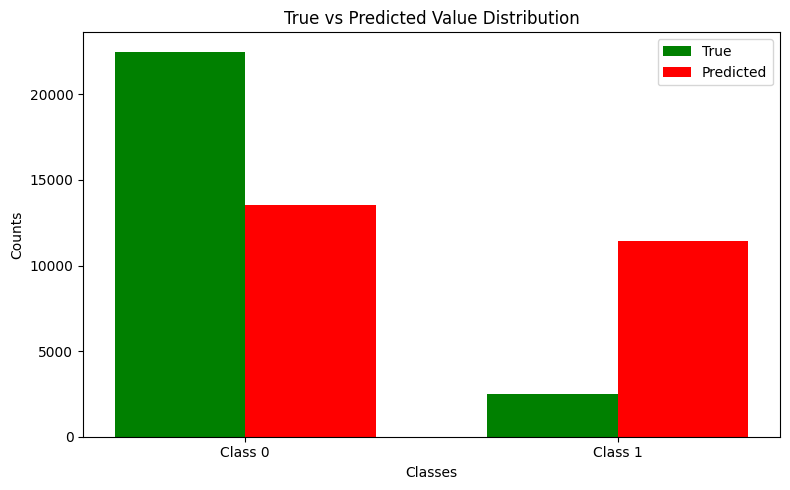

In [24]:
import numpy as np
import matplotlib.pyplot as plt

true_data = {int(row['class']): row['true_count'] for row in comparison_data if row['class'] is not None}
predicted_data = {int(row['class']): row['predicted_count'] for row in comparison_data if row['class'] is not None}

labels = list(true_data.keys())
true_counts = list(true_data.values())
predicted_counts = list(predicted_data.values())

labels = [f"Class {int(c)}" for c in labels]
x = np.arange(len(labels))
bar_width = 0.35

plt.figure(figsize=(8, 5))
plt.bar(x - bar_width/2, true_counts, bar_width, label='True', color='green')
plt.bar(x + bar_width/2, predicted_counts, bar_width, label='Predicted', color='red')

plt.xlabel("Classes")
plt.ylabel("Counts")
plt.title("True vs Predicted Value Distribution")
plt.xticks(x, labels)
plt.legend()
plt.tight_layout()
plt.show()